In [ ]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
from torch import device
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/EE782_assignment2_dataset/lfw-deepfunneled'
files = os.listdir(path)
files = files[:int(0.5*len(files))]
label = []
directory = []
for file in files:
    path_new = path+'/'+file
    images_path = os.listdir(path_new)
    for image in images_path:
        label.append(file)
        directory.append(image)
data = pd.DataFrame({'label':label, 'directory':directory})
data = data[:int((data.shape[0]))]
data.head()

,label,directory
0,Audrey_Lacroix,Audrey_Lacroix_0001.jpg
1,Aung_San_Suu_Kyi,Aung_San_Suu_Kyi_0002.jpg
2,Aung_San_Suu_Kyi,Aung_San_Suu_Kyi_0001.jpg
3,Augustin_Calleri,Augustin_Calleri_0001.jpg
4,Augustin_Calleri,Augustin_Calleri_0003.jpg


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      607 non-null    object
 1   directory  607 non-null    object
dtypes: object(2)
memory usage: 9.6+ KB


In [ ]:
# funtion to convert image to numpy array
from keras.preprocessing.image import load_img
def img2vector(data_frame):
    '''input: data frame
       output: numpy array of images, numpy array of images converted to vector'''
    label = []
    images = []
    for idx in range(0,data_frame.shape[0]):
        person = data_frame['label'][idx]    # extracting the label of the image
        directory = data_frame['directory'][idx]   # extraction the directory of the image
        img_path = path +'/'+person+'/'+ directory
        img = load_img(img_path, target_size=(64, 64), grayscale=False)   # resizing to 128x128 and converting to grey scale to reduce channels
        images.append(img)
        label.append(1)
    return images, label

images, label = img2vector(data)   # the vector images contains all the images and images_vec contains images converted to vector
print('shape of images = ', len(images))
data['image'] = images
data['is_real'] = label
data.head()

shape of images =  607


,label,directory,image,is_real
0,Audrey_Lacroix,Audrey_Lacroix_0001.jpg,<PIL.Image.Image image mode=RGB size=64x64 at ...,1
1,Aung_San_Suu_Kyi,Aung_San_Suu_Kyi_0002.jpg,<PIL.Image.Image image mode=RGB size=64x64 at ...,1
2,Aung_San_Suu_Kyi,Aung_San_Suu_Kyi_0001.jpg,<PIL.Image.Image image mode=RGB size=64x64 at ...,1
3,Augustin_Calleri,Augustin_Calleri_0001.jpg,<PIL.Image.Image image mode=RGB size=64x64 at ...,1
4,Augustin_Calleri,Augustin_Calleri_0003.jpg,<PIL.Image.Image image mode=RGB size=64x64 at ...,1


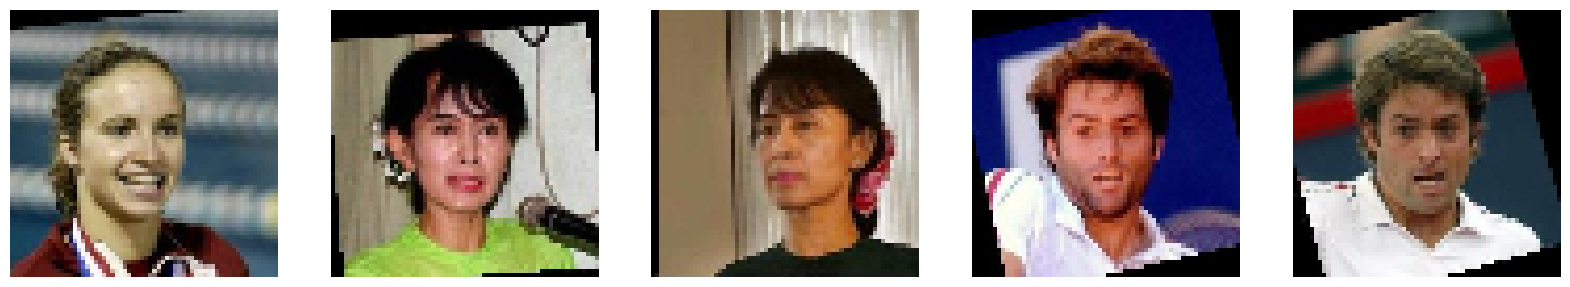

In [ ]:
# plottig randomly 5 images from the dataframe
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(data.image[i])
    plt.axis('off')
plt.show()

In [ ]:
data.info() # for analysis of the data frame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      607 non-null    object
 1   directory  607 non-null    object
 2   image      607 non-null    object
 3   is_real    607 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 19.1+ KB


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Defining a custom dataset class specific to the data given
class CustomImageDataset:
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)   # returning the length of the data frame

    def __getitem__(self, idx):   # returning the image and label of the image at the index idx
        img = self.data.iloc[idx,2]  # converting image to tensor
        label = torch.tensor(self.data.iloc[idx, 3], dtype=torch.float32)   # converting label to tensor

        if self.transform:
            img = self.transform(img)    # converting image to tensor
        return img

# Defining data transform from PIL (which is in data frame) image to tensor (to feed the model)
import numpy as np
import torchvision.transforms as tt

# Defining the data transform
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

data_transform = tt.Compose([
    tt.Resize((64, 64)),    # reshaping the image if not previously in the desired shape which is 224 x 224 x 3
    tt.ToTensor(),   # converting image to tensor
    tt.Normalize(*stats)   # normalizing the image
])



In [ ]:
batch_size = 64
learning_rate = 0.0002
latent_size = 512

# creating a dataloader
real_images = DataLoader(CustomImageDataset(dataframe=data, transform=data_transform), batch_size=batch_size, shuffle=True)

In [ ]:
from torch.cuda import is_available
if torch.cuda.is_available():
  print('cuda is available')
else:
  print('runnung on cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda is available


In [ ]:
# defining the discriminator
discriminator = nn.Sequential(     # input size = 3 x 64 x 64
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),     # output size = 64 x 32 x 32

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),   # output size = 128 x 16 x 16

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),   # output size = 256 x 8 x 8

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),   # output size = 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),    # output size = 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

latent_size = 128
generator = nn.Sequential(    # input size = 128 x 1 x 1
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),    # output size = 512 x 4 x 4

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),     # output size = 256 x 8 x 8

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),    # output size = 128 x 16 x 16

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),  # output size = 64 x 32 x 32

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias = False),
    nn.Tanh()     # output size = 3 x 64 x 64
)


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)    # real_preds is the output of the discriminator for real images
    real_targets = torch.ones(real_images.size(0), 1, device=device)     # real_targets is the target for real images
    real_loss = F.binary_cross_entropy(real_preds, real_targets)    # real_loss is the loss for real images
    real_score = torch.mean(real_preds).item()     # real_score is the mean of the output of the discriminator for real images

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)   # latent is the random gaussian noise
    fake_images = generator(latent)    # fake_images is the output of the generator for random noise

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)    # fake_targets is the target for fake images
    fake_preds = discriminator(fake_images)      # fake_preds is the output of the discriminator for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)      # fake_loss is the loss for fake images
    fake_score = torch.mean(fake_preds).item()     # fake_score is the mean of the output of the discriminator for fake images

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):

    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1).to(device) #random noice
    fake_images = generator.forward(latent).to(device) #fake images generated

    # Try to fool the discriminator
    preds = discriminator.forward(fake_images).to(device) #getting the predictions of discriminator for fake images
    targets = torch.ones(batch_size, 1).to(device) #setting 1 as targets so the discriminator can be fooled
    loss = F.binary_cross_entropy(preds, targets) #comparing

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item(),latent

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    fake_images = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.to(device).parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.to(device).parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_img in real_images:

            # Train discriminator
            real_img= real_img.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_img, opt_d)

            # Train generator
            loss_g, latent = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        if((epoch+1)%20==0):
          print("Epoch [{}/{}], loss_g: {}, loss_d: {}, real_score: {}, fake_score: {}".format(
              epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        # save_samples(epoch+start_idx, latent, show=False)
        # after every epoch denorm the image and save the fake image generated in a list to print later
        with torch.no_grad():
            fake_images.append(denorm(generator(latent).reshape(-1, 3, 64, 64)).cpu().detach())

    return losses_g, losses_d, latent, fake_scores, fake_images, real_scores

In [ ]:
# train the model
losses_g, losses_d, latent, fake_scores, fake_images, real_scores = fit(epochs=300, lr=0.0005)

Epoch [20/300], loss_g: 5.624111652374268, loss_d: 0.04347176104784012, real_score: 0.9680625796318054, fake_score: 0.009737633168697357
Epoch [40/300], loss_g: 5.374336242675781, loss_d: 0.2990642189979553, real_score: 0.9519788026809692, fake_score: 0.15617936849594116
Epoch [60/300], loss_g: 3.723658323287964, loss_d: 0.09732706099748611, real_score: 0.9284656643867493, fake_score: 0.01767304353415966
Epoch [80/300], loss_g: 4.526323318481445, loss_d: 0.2269861102104187, real_score: 0.8485993146896362, fake_score: 0.03176771104335785
Epoch [100/300], loss_g: 6.464705467224121, loss_d: 0.03694525733590126, real_score: 0.9770550727844238, fake_score: 0.012617202475667
Epoch [120/300], loss_g: 8.619657516479492, loss_d: 0.03574348986148834, real_score: 0.9780066609382629, fake_score: 0.0095802191644907
Epoch [140/300], loss_g: 10.045900344848633, loss_d: 0.013759149238467216, real_score: 0.9952097535133362, fake_score: 0.008652194403111935
Epoch [160/300], loss_g: 10.108742713928223, l

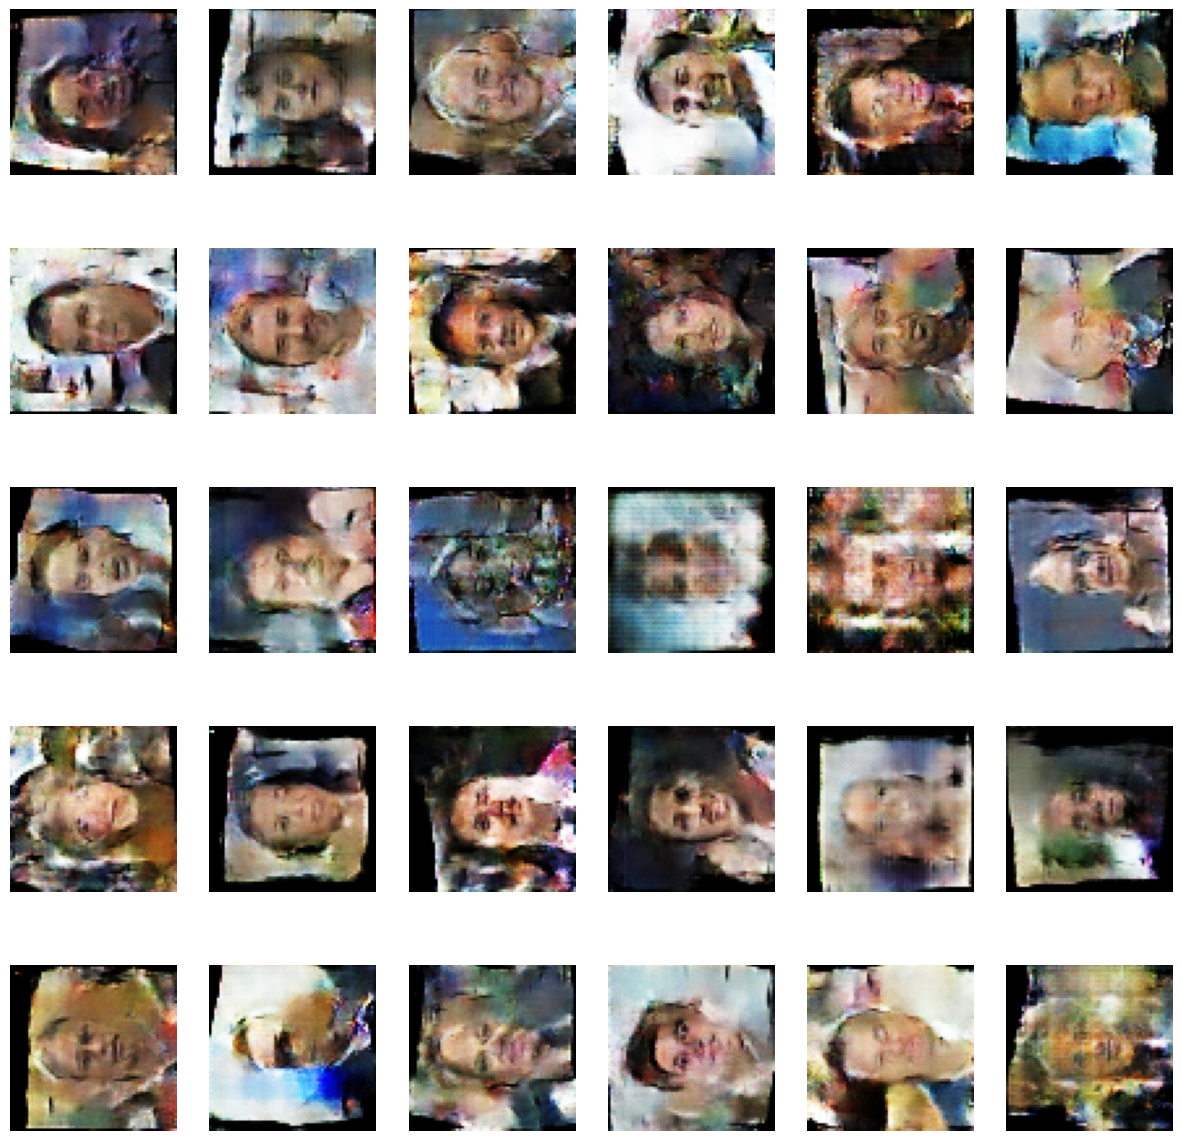

In [ ]:
# print all the the saved images in a grid
import random
plt.figure(figsize=(15,15))
j=0
for i in range(0,300,10):
  plt.subplot(5,6,j+1)
  j=j+1
  plt.imshow(fake_images[i][random.randint(0,63)].transpose(0,2))
  plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

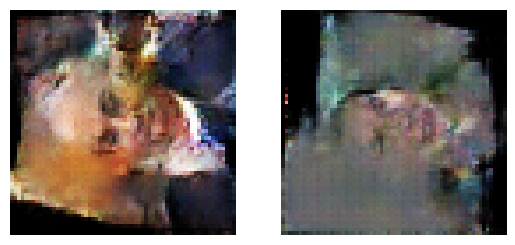

In [ ]:
# printing first image and last one
plt.subplot(1,2,1)
plt.imshow(fake_images[0][0].transpose(0,2))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(fake_images[-1][0].transpose(0,2))
plt.axis('off')

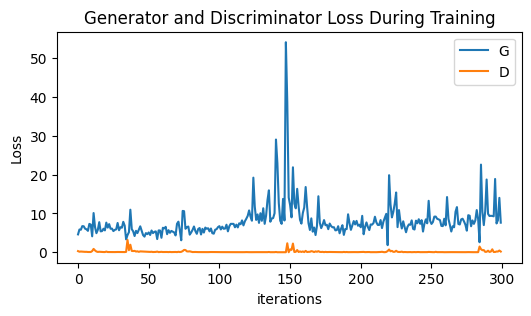

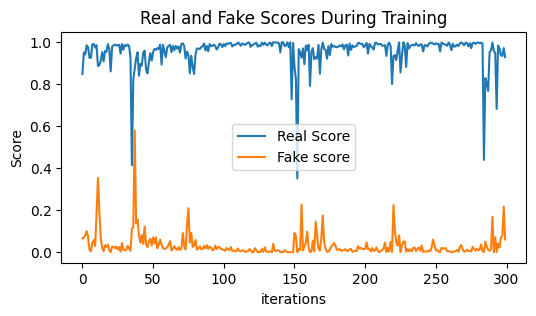

In [ ]:
# plot the losses
plt.figure(figsize=(6,3))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_g,label="G")
plt.plot(losses_d,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plot the scores
plt.figure(figsize=(6,3))
plt.title("Real and Fake Scores During Training")
plt.plot(real_scores,label="Real Score")
plt.plot(fake_scores,label="Fake score")
plt.xlabel("iterations")
plt.ylabel("Score")
plt.legend()
plt.show()

In [ ]:
# save the model
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

# Bonus Section